# Testing PEC and ZNE on noisy quantum computers

**Description**

Runs various error mitigation techniques (ZNE and PEC) on various hardware or simulator offerings (IonQ, Rigetti, IBMQ) with different benchmark circuits (randomized benchmark or mirror).

## Setup

In [1]:
import os
import functools
import time
from typing import Dict, List, Tuple, Union

# Plotting imports.
import matplotlib.pyplot as plt
plt.rcParams.update({"font.family": "serif", "font.size": 15})
%matplotlib inline

# Third-party imports.
import cirq
import networkx as nx
import numpy as np
import pandas as pd

# Qiskit imports.
import qiskit
import qiskit.ignis.verification.randomized_benchmarking as rb
from qiskit.transpiler.passes import RemoveBarriers, RemoveFinalMeasurements
from qiskit.circuit import Gate

# Mitiq imports.
from mitiq.interface import convert_to_mitiq, convert_from_mitiq
from mitiq import benchmarks, pec, zne

# For hardware device offerings.
from braket.aws import AwsDevice
from braket.devices import LocalSimulator
from braket.circuits import Circuit, gates, Noise

/var/folders/vb/gympzbzn6jn5dqnj0gr2mc1w0000gp/T/ipykernel_36907/2571622115.py:19: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  import qiskit.ignis.verification.randomized_benchmarking as rb


## Problem definition

### Parameters

In [2]:
# Option to use a noisy simulator instead of hardware backend.
use_noisy_simulator: bool = True  

# Minimum depth circuit to use.
min_depth: int = 1          
# Random seed for circuit generation.
seed: int = 1               

# Minimum noise scale factor.
min_scale_factor: int = 1   
# Maximum noise scale factor.
max_scale_factor: int = 3   

# Step between noise scale factors.
step_scale_factor: int = 1  

# Total number of shots to use.
# For PEC, the shots per circuit is shots / num_samples.
# For ZNE, the shots per circuit is shots / len(scale_factors).
shots: int = 10_000     
# Number of samples (circuits) to use in PEC.    
num_samples: int = 100  

# Display verbose output.    
verbose: bool = True  
# Give queue updates every this many seconds when running on hardware device.    
verbose_update_time: int = 30  

# Save data (cnot_counts, oneq_counts, true_values, noisy_values, zne_values, etc.).
save_data: bool = True  

### Circuit parameters

In [3]:
# Benchmark circuit type. Supported types are "rb" and "mirror".
circuit_type: str = "rb"  

# Qubits to use on the experiment. 
num_qubits = 3
qubits = [j for j in range(num_qubits)]

# Split qubits into 2-qubit pairs (assuming a chain connectivity). 
rb_pattern = [[qa, qb] for qa, qb in zip(qubits[0:-1:2], qubits[1::2])]
if len(qubits) % 2 == 1:
    # For an odd number of qubits, append final individual qubit to the RB pattern.
    rb_pattern.append([qubits[-1]])
print("Qubit indeces:", qubits)
print("RB pattern:", rb_pattern)
    
    
# Maximum depth circuit to use.    
max_depth: int = 20

# Step to create a list of depths to run at.
step_depth: int = 2
        
# Average results over this many trials (circuit instances) at each depth.
trials: int = 4      

Qubit indeces: [0, 1, 2]
RB pattern: [[0, 1], [2]]


### Hardware parameters

In [4]:
# Hardware backend device type. Supported types are "rigetti", "ibmq", and "ionq".
hardware_type: str = "ibmq"

backend = {
    "rigetti": "arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-2", # arn:aws:braket:::device/qpu/rigetti/Aspen-11
    "ibmq": "ibmq_lima",
    "ionq": "arn:aws:braket:::device/qpu/ionq/ionQdevice",
}.get(hardware_type)

### IBM qubit settings

In [5]:
if hardware_type == "ibmq":
    # Physical qubits of ibmq-kolkata with a chain-like connectivity.
    ibm_lima_ordering = [0, 1, 3, 4, 2]
    ibm_kolkata_ordering = [0, 1, 4, 7, 10, 12, 15, 18, 21, 23, 24, 25, 22, 19, 16, 14, 11, 8, 5, 3, 2]

    if len(qubits) <= 5:
        # Assume ibmq-lima device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_lima_ordering[:len(qubits)] 
    elif len(qubits) <= len(ibm_kolkata_ordering):
        # Assume ibmq-kolkata device. Take n adjacent physical qubits.
        physical_ibm_qubits = ibm_kolkata_ordering[:len(qubits)]  
    else:
        raise ValueError(f"Number of qubits {num_qubits} too large.")

    print("IBM physical qubits:", physical_ibm_qubits)

IBM physical qubits: [0, 1, 3]


### Rigetti qubit settings

In [6]:
if hardware_type == "rigetti":
    test_backend = AwsDevice(backend)
    nx.draw_kamada_kawai(test_backend.topology_graph, with_labels=True, font_color="white")

    # Sanity check for fidelity information to be extracted from backend.
    test_twoq_data = pd.DataFrame.from_dict(test_backend.properties.provider.specs["2Q"]).T
    test_twoq_data.sort_values(by=["fCZ"], ascending=False).head()    
    test_twoq_fid = test_twoq_data["fCZ"]

In [7]:
if hardware_type == "rigetti":
    # This is the manually written qubit mapping based on the above plot. 
    rigetti_qubit_mapping = {0: 113, 1: 10, 2: 17}

### Global folding with random rotation barriers

In [8]:
def make_rotation_barrier(circuit, delta):
    qubits = list(circuit.all_qubits())
    delta_x = np.random.choice([1.0, -1.0]) * delta
    delta_y = np.random.choice([1.0, -1.0]) * delta
    delta_z = np.random.choice([1.0, -1.0]) * delta
    barrier = cirq.Circuit()
    for q in qubits:
        barrier.append(cirq.rx(delta_x)(q))
        barrier.append(cirq.ry(delta_y)(q))
        barrier.append(cirq.rz(delta_z)(q))
    return barrier

def fold_with_rotation_barriers(circuit, scale_factor, delta):

    base_circuit, circ_type = convert_to_mitiq(circuit)

    ####### Adapted from Mitiq ############
    folded = base_circuit.copy()
    # Determine the number of global folds and the final fractional scale
    num_global_folds, fraction_scale = divmod(scale_factor - 1, 2)
    # Do the global folds
    for _ in range(int(num_global_folds)):
        folded += make_rotation_barrier(base_circuit, delta)
        folded += cirq.Circuit(cirq.inverse(base_circuit))
        folded += make_rotation_barrier(base_circuit, delta)
        folded += cirq.Circuit(base_circuit)

    # Fold remaining gates until the scale is reached
    operations = list(base_circuit.all_operations())
    num_to_fold = int(round(fraction_scale * len(operations) / 2))

    if num_to_fold > 0:

        # Create the inverse of the final partial circuit
        inverse_partial = cirq.Circuit()
        num_partial = 0
        for moment in base_circuit[::-1]:
            new_moment = cirq.Moment()
            for op in moment.operations[::-1]:
                new_moment = new_moment.with_operation(cirq.inverse(op))
                num_partial += 1
                if num_partial == num_to_fold:
                    break
            inverse_partial.append(new_moment)
            if num_partial == num_to_fold:
                break
        # Append partially folded circuit
        folded += make_rotation_barrier(base_circuit, delta)
        folded += inverse_partial
        folded += make_rotation_barrier(base_circuit, delta)
        folded += cirq.inverse(inverse_partial)
    #########
    
    folded_converted = convert_from_mitiq(folded, circ_type)
    return folded_converted

### Error mitigation options

In [9]:
# Error mitigation type. Supported typed are "zne" and "pec".
mitigation_type: str = "zne"

# Random angles for rotation barriers    
delta = 0.0001

# Noise scaling method.
if hardware_type == "ionq":
    fold_method = functools.partial(fold_with_rotation_barriers, delta=delta)
else:
    fold_method = zne.scaling.fold_global

depths = list(range(min_depth, max_depth + 1, step_depth))

scale_factors = tuple(range(min_scale_factor, max_scale_factor + 1, step_scale_factor))

print(f"Depths: {depths}")
print(f"Scale factors: {scale_factors}")

Depths: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19]
Scale factors: (1, 2, 3)


### Hardware architecture

If the user selects the option to run on an actual hardware offering, define the architectural layout of the quantum device. Otherwise, invoke the appropriate simulator.

In [10]:
computer = nx.Graph()

# Assume chain-like connectivity
computer.add_edges_from([(qa, qb) for qa, qb in zip(qubits[:-1], qubits[1:])])

# Add reversed edges to computer graph.
# This is important to represent CNOT gates with target and control reversed.
computer = nx.to_directed(computer)

# Get the backend to run on and a simulated backend for comparing results.
if use_noisy_simulator:
    if hardware_type == "ionq" or hardware_type == "rigetti":
        noisy_backend = LocalSimulator("braket_dm")
        
    elif hardware_type == "ibmq":
        from qiskit.providers.fake_provider import FakeLima, FakeKolkataV2
        
        if len(qubits) <= 5:
            noisy_backend = FakeLima()
        else:
            noisy_backend = FakeKolkataV2()

# Specify both the hardware device and device architecture (computer):
else:

    if hardware_type == "ionq" or hardware_type == "rigetti":
        noisy_backend = AwsDevice(backend)
        
    elif hardware_type == "ibmq":
        provider = qiskit.IBMQ.load_account()
        noisy_backend = provider.get_backend(backend)
        print(f"View {backend} job status at https://quantum-computing.ibm.com/jobs")        

# Check if RB-pattern is consistent with device topology.
for edge in rb_pattern:
    if len(edge) == 2:
        if edge not in computer.edges:
            raise ValueError("The option rb_pattern is not consistent with the device topology.")
        
# Set ideal backends for simulator-selected options.
if hardware_type == "ionq" or hardware_type == "rigetti":
    ideal_backend = LocalSimulator("default")

elif hardware_type == "ibmq":
    ideal_backend = qiskit.Aer.get_backend("aer_simulator")
    

print("Computer connectivity (used only for mirror circuits):", computer.edges)
print("Noisy backend", noisy_backend)
print("Ideal backend", ideal_backend)

Computer connectivity (used only for mirror circuits): [(0, 1), (1, 0), (1, 2), (2, 1)]
Noisy backend fake_lima
Ideal backend aer_simulator


### Benchmark circuit

In [11]:
def named_qubit_to_line_qubit(named_qubit: str) -> cirq.LineQubit:
    """Extract qubit number assuming "_" is used as a word separator."""
    digits = [int(s) for s in named_qubit.name.split("_") if s.isdigit()]
    if len(digits) == 1:
        return cirq.LineQubit(digits[0])
    else:
        raise RuntimeError("Failed to identify qubit number.")

In [12]:
if circuit_type == "rb":
    def get_circuit(depth: int, seed: int) -> Union[Tuple[cirq.Circuit, str], Tuple[qiskit.QuantumCircuit, str]]:
        circuit = rb.randomized_benchmarking_seq(
            length_vector=[depth], 
            rb_pattern=rb_pattern,
            group_gates="0", 
            rand_seed=seed,
        )[0][0][0]

        # Remove barriers and measurements.
        circuit = RemoveFinalMeasurements()(RemoveBarriers()(circuit))

        if hardware_type == "ionq" or hardware_type == "rigetti":
            # Qiskit --> Cirq.
            cirq_circuit, _ = convert_to_mitiq(circuit)
            circuit_with_linequbits = cirq_circuit.transform_qubits(named_qubit_to_line_qubit)

            # Cirq --> Braket.
            return convert_from_mitiq(circuit_with_linequbits, "braket"), "0" * len(qubits)
        
        elif hardware_type == "ibmq":
            # Hack: Remove classical register and rename qubit register.
            return convert_from_mitiq(convert_to_mitiq(circuit)[0], "qiskit"), "0" * len(qubits)

elif circuit_type == "mirror":
    def get_circuit(depth: int, seed: int) -> Union[Tuple[cirq.Circuit, str], Tuple[qiskit.QuantumCircuit, str]]:
        
        return_type = "braket" if hardware_type == "ionq" or hardware_type == "rigetti" else "qiskit"
        circuit, correct_bitstring = benchmarks.generate_mirror_circuit(
            nlayers=depth,
            two_qubit_gate_prob=1.0,
            connectivity_graph=computer,
            two_qubit_gate_name="CNOT",
            seed=seed,
            return_type=return_type,
        )        
        
        if hardware_type == "ionq" or hardware_type == "rigetti":
            return circuit, correct_bitstring
        elif hardware_type == "ibmq":
            # Reversed because Qiskit is wrong endian.
            return circuit, "".join(map(str, correct_bitstring[::-1]))              

### Gateset compilation functions

In [13]:
def compile_to_rigetti_qubits(circuit: Circuit, rigetti_qubit_mapping: Dict[int, int]) -> Circuit:
    compiled = Circuit()
    for instr in circuit.instructions:
        braket_qubits = instr.target
        rigetti_qubits = braket_qubits.map(rigetti_qubit_mapping)
        compiled.add_instruction(gates.Instruction(instr.operator, rigetti_qubits))
    return compiled

In [14]:
def compile_to_rigetti_gateset(circuit: Circuit) -> Circuit:
    """Compiles AWS gates to Rigetti gateset. Taken from: 
    https://mitiq.readthedocs.io/en/stable/examples/braket_mirror_circuit.html"""
    compiled = Circuit()
    
    for instr in circuit.instructions:
        if isinstance(instr.operator, gates.Vi):
            compiled.add_instruction(gates.Instruction(gates.Rx(-np.pi / 2), instr.target))
        elif isinstance(instr.operator, gates.V):
            compiled.add_instruction(gates.Instruction(gates.Rx(np.pi / 2), instr.target))
        elif isinstance(instr.operator, gates.Ry):
            compiled.add_instruction(gates.Instruction(gates.Rx(-np.pi / 2), instr.target))
            compiled.add_instruction(gates.Instruction(gates.Rz(-instr.operator.angle), instr.target))
            compiled.add_instruction(gates.Instruction(gates.Rx(np.pi / 2), instr.target))
        elif isinstance(instr.operator, gates.Y):
            compiled.add_instruction(gates.Instruction(gates.Rx(-np.pi / 2), instr.target))
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi), instr.target))
            compiled.add_instruction(gates.Instruction(gates.Rx(np.pi / 2), instr.target))
        elif isinstance(instr.operator, gates.X):
            compiled.add_instruction(gates.Instruction(gates.Rx(np.pi), instr.target))
        elif isinstance(instr.operator, gates.Z):
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi), instr.target))
        elif isinstance(instr.operator, gates.S):
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi / 2), instr.target))
        elif isinstance(instr.operator, gates.Si):
            compiled.add_instruction(gates.Instruction(gates.Rz(-np.pi / 2), instr.target))
        elif isinstance(instr.operator, gates.H):          
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi / 2), instr.target))
            compiled.add_instruction(gates.Instruction(gates.Rx(np.pi / 2), instr.target))
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi / 2), instr.target))            
        elif isinstance(instr.operator, gates.CNot):
            # First Hadamard
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi / 2), instr.target[1]))
            compiled.add_instruction(gates.Instruction(gates.Rx(np.pi / 2), instr.target[1]))
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi / 2), instr.target[1]))
            
            # Controlled-Z
            compiled.add_instruction(gates.Instruction(gates.CZ(), instr.target))

            # Second Hadamard
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi / 2), instr.target[1]))
            compiled.add_instruction(gates.Instruction(gates.Rx(np.pi / 2), instr.target[1]))
            compiled.add_instruction(gates.Instruction(gates.Rz(np.pi / 2), instr.target[1]))
        else:
            compiled.add_instruction(instr)
    
    return compiled

### Operation representations

In [15]:
def get_cnot_error(edge: Tuple[int, int] = None) -> float:
    # If we use a simulator, we can't get any error probability from any specific 
    # device so we hardcode a small "reasonable" CNOT error probability.
    if use_noisy_simulator and hardware_type != "ibmq":
        cnot_error_prob = 0.01

    elif hardware_type == "ibmq":
        cnot_error_prob = noisy_backend.properties().gate_error("cx", qubits=edge)

    elif hardware_type == "rigetti":
        rigetti_edge = [rigetti_qubit_mapping[node] for node in edge]
        
        twoq_data = pd.DataFrame.from_dict(noisy_backend.properties.provider.specs["2Q"]).T
        twoq_data.sort_values(by=["fCZ"], ascending=False).head()
        twoq_fid = twoq_data["fCZ"]
        cnot_error_prob = 1.0 - twoq_fid[pd.RangeIndex(*sorted(rigetti_edge))][0]
        
    elif hardware_type == "ionq":
        cnot_error_prob = 1 - noisy_backend.properties.provider.fidelity["2Q"]["mean"]
    
    print(f"cnot_error_prob for edge {edge}: {cnot_error_prob}")
    return cnot_error_prob

def get_cnot_representation(edge: Tuple[int, int]) -> pec.OperationRepresentation:
    if hardware_type == "ibmq":
        cnot_circuit = cirq.Circuit(
            cirq.CNOT(
                cirq.NamedQubit(f"q_{str(edge[0])}"),
                cirq.NamedQubit(f"q_{str(edge[1])}")
            )
        )
    elif hardware_type == "ionq" or hardware_type == "rigetti":
        cnot_circuit = cirq.Circuit(
            cirq.CNOT(
                cirq.LineQubit(edge[0]),
                cirq.LineQubit(edge[1])
            )
        )              

    rep_exact_prob = 1 - np.sqrt(1 - get_cnot_error(edge))
    return pec.represent_operation_with_local_depolarizing_noise(
        cnot_circuit, 
        noise_level=rep_exact_prob,
    )


def get_representations(computer: nx.Graph) -> List[pec.OperationRepresentation]:
    return [get_cnot_representation(edge) for edge in computer.edges]

### CNOT count utility functions

In [16]:
def get_num_cnot_count(circuit: Union[cirq.Circuit, qiskit.QuantumCircuit]) -> int:
    """Determine number of cnot gates in a given `Circuit` object."""
    
    # Count CNOT gates for `cirq`-type circuit objects:
    if hardware_type == "ionq" or hardware_type == "rigetti":
        num_cnots: int = 0
        for instruction in circuit.instructions:
            if isinstance(instruction.operator, gates.CNot):
                num_cnots += 1
        return num_cnots
    
    # Count CNOT gates for `qiskit`-type circuit objects:
    elif hardware_type == "ibmq":
        return circuit.count_ops().get("cx")

def get_avg_cnot_count(circuits: Union[List[cirq.Circuit], List[qiskit.QuantumCircuit]]) -> float:
    """Determine average number of cnot gates present in 
    list of either `Circuit` or `QuantumCircuit` objects."""    
    
    # Average CNOT gates for `cirq`-type circuit objects:
    if hardware_type == "ionq" or hardware_type == "rigetti":
        total_cnots: List[int] = []
        for circuit in circuits:
            num_cnots = get_num_cnot_count(circuit)
            total_cnots.append(num_cnots)
        return np.average(total_cnots)
    
    # Average CNOT gates for `qiskit`-type circuit objects:
    elif hardware_type == "ibmq":
        return np.average([c.count_ops().get("cx") for c in circuits])
    

def get_oneq_count(circuit: Union[cirq.Circuit, qiskit.QuantumCircuit]) -> int:
    if hardware_type == "ionq" or hardware_type == "rigetti":
        return len(circuit.instructions) - get_num_cnot_count(circuit)
    elif hardware_type == "ibmq":
        return len(circuit) - get_num_cnot_count(circuit)

### Executor

In [17]:
def execute(
    circuits: Union[cirq.Circuit, List[cirq.Circuit]], 
    backend,
    shots: int,
    correct_bitstring: str,
    verbose: bool = verbose,
    is_noisy: bool = True,
) -> List[float]:
    """Executes the input circuit(s) and returns ⟨A⟩, where 
    A = |correct_bitstring⟩⟨correct_bitstring| for each circuit.
    """
    if not isinstance(circuits, list):
        circuits = [circuits]
    
    if verbose:
        # Calculate average number of CNOT gates per circuit.
        print(f"Executing {len(circuits)} circuit(s) on {backend}.")            
        print(f"Average cnot count in circuits: {get_avg_cnot_count(circuits)}")

    # Store all circuits to run in list to be returned.
    to_run: Union[List[braket.Circuit], List[qiskit.QuantumCircuit]] = []
    
    # Compile circuits to appropriate gateset for either Rigetti or IonQ.
    if hardware_type == "ionq" or hardware_type == "rigetti":
        for circuit in circuits:
            if not is_noisy:
                circuit_to_run = circuit.copy()
            elif use_noisy_simulator and is_noisy:
                circuit_to_run = circuit.copy()
                cnot_error_prob = get_cnot_error()
                circuit_to_run.apply_gate_noise(Noise.Depolarizing(probability=cnot_error_prob/2), target_gates=gates.CNot)
            elif not use_noisy_simulator and is_noisy:
                if hardware_type == "ionq":
                    circuit_to_run = circuit
                elif hardware_type == "rigetti":
                    compiled_circuit = compile_to_rigetti_gateset(circuit)
                    circuit_with_compiled_qubits = compile_to_rigetti_qubits(compiled_circuit, rigetti_qubit_mapping)
                    circuit_to_run = Circuit().add_verbatim_box(circuit_with_compiled_qubits)
            to_run.append(circuit_to_run)

    # Transpile circuits for IBMQ.
    elif hardware_type == "ibmq":
        for circuit in circuits:
            circuit_to_run = circuit.copy()
            
            circuit_to_run.measure_all()
            to_run.append(
                qiskit.transpile(
                    circuit_to_run,
                    backend=backend,
                    initial_layout=physical_ibm_qubits,
                    optimization_level=0, # Otherwise RB circuits are simplified to empty circuits.
                )
            )

    if verbose:
        # Calculate average number of CNOT gates per compiled circuit.
        print(f"Average cnot count in compiled circuits: {get_avg_cnot_count(to_run)}")
        
    # Process each job for either IonQ or Rigetti.
    if hardware_type == "ionq" or hardware_type == "rigetti":
        
        # Make a copy of circuits for safety/redundancy.
        to_run_with_noise = []
        for circ in to_run:
            circuit_to_run = circ.copy()
            to_run_with_noise.append(circuit_to_run)
        
        results: List[float] = []
        for circ_to_run in to_run_with_noise:
            if is_noisy and not use_noisy_simulator and hardware_type == "rigetti":
                print("Executing on Rigetti.")
                job_result = backend.run(circ_to_run, disable_qubit_rewiring=True, shots=shots).result()
            elif is_noisy and not use_noisy_simulator and hardware_type == "ionq":
                print("Executing on IonQ.")
                job_result = backend.run(circ_to_run, shots=shots).result()
            else:
                print("Executing on simulator.")
                job_result = backend.run(circ_to_run, shots=shots).result()

            print("task_id:", job_result.task_metadata.id)                
            results.append(job_result.measurement_probabilities.get("".join(map(str, correct_bitstring)), 0.0))
        print("Results:", results)

        return results
   
    # Process each job for IBMQ.
    elif hardware_type == "ibmq":
        # Run and get counts.
        job = backend.run(
            to_run,
            # Reset qubits to ground state after each sample.
            init_qubits=True,  
            shots=shots,
        )
        # IBMQ uses online queue for processing jobs.
        if verbose and not use_noisy_simulator:
            time.sleep(3)
            while not job.in_final_state():
                print(f"Queue position: {job.queue_position()}")
                time.sleep(verbose_update_time)
            print()

        print(f"Correct bitstring: {correct_bitstring}")
        if len(circuits) == 1:
            return [job.result().get_counts().get(correct_bitstring, 0.0) / shots]
        return [count.get(correct_bitstring, 0.0) / shots for count in job.result().get_counts()]

## Experiment

In [18]:
cnot_counts, oneq_counts = [], []
true_values, noisy_values = [], []
zne_values, pec_values = [], []

noise_scaled_expectation_values = []

for depth in depths:
    print("Status: On depth", depth, end="\n\n")
    
    cnot_depth_counts, oneq_depth_counts = [], []
    true_depth_values, noisy_depth_values = [], []
    zne_depth_values, pec_depth_values = [], []

    noise_scaled_expectation_depth_values = []

    for trial in range(trials):
        # Local seed is calculated in this way to ensure that we don't get repeat values in loop.        
        local_seed = 10**6 * depth + 10**3 * seed + trial
        
        circuit, correct_bitstring = get_circuit(depth, local_seed)

        true_value, = execute(circuit, ideal_backend, shots, correct_bitstring, verbose=verbose, is_noisy=False)
        noisy_value, = execute(circuit, noisy_backend, shots, correct_bitstring, verbose=verbose, is_noisy=True)
        
        if mitigation_type == "zne":
            zne_executor = functools.partial(
                execute, 
                backend=noisy_backend, 
                shots=shots // len(scale_factors),
                correct_bitstring=correct_bitstring,
                verbose=verbose,
            )                        
            richardson_factory = zne.inference.RichardsonFactory(scale_factors=scale_factors)            
            zne_value = zne.execute_with_zne(circuit, 
                                             zne_executor, 
                                             scale_noise=fold_method, 
                                             factory=richardson_factory)
            zne_depth_values.append(zne_value)       
            noise_scaled_expectation_depth_values.extend(richardson_factory.get_expectation_values())
        
        elif mitigation_type == "pec":
            pec_executor = functools.partial(
                execute, 
                backend=noisy_backend, 
                shots=shots // num_samples,
                correct_bitstring=correct_bitstring,
                verbose=verbose,
            )
            pec_value = pec.execute_with_pec(
                circuit, 
                pec_executor, 
                representations=get_representations(computer), 
                num_samples=num_samples,
                random_state=local_seed,
            )
            pec_depth_values.append(pec_value)

        cnot_depth_counts.append(get_num_cnot_count(circuit))
        oneq_depth_counts.append(get_oneq_count(circuit))
        
        true_depth_values.append(true_value)
        noisy_depth_values.append(noisy_value)
    
    cnot_counts.append(cnot_depth_counts)
    oneq_counts.append(oneq_depth_counts)
    
    true_values.append(true_depth_values)
    noisy_values.append(noisy_depth_values)
    
    noise_scaled_expectation_values.append(noise_scaled_expectation_depth_values)    
    
    if mitigation_type == "zne":
        zne_values.append(zne_depth_values)
    elif mitigation_type == "pec":
        pec_values.append(pec_depth_values)

Status: On depth 1

Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 000
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 000
Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 000
Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 000
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 4.0
Average cnot count in compiled circuits: 4.0
Correct bitstring: 000
Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 8.0
Average cnot count in compiled circuits: 8.0
Correct bitstring: 000
Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 6.0
Average cnot count in compiled circuits: 6.0
Corr

Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 38.0
Average cnot count in compiled circuits: 38.0
Correct bitstring: 000
Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 16.0
Average cnot count in compiled circuits: 16.0
Correct bitstring: 000
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 16.0
Average cnot count in compiled circuits: 16.0
Correct bitstring: 000
Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 32.666666666666664
Average cnot count in compiled circuits: 32.666666666666664
Correct bitstring: 000
Status: On depth 11

Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 19.0
Average cnot count in compiled circuits: 19.0
Correct bitstring: 000
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 19.0
Average cnot count in compiled circuits: 19.0
Correct bitstring: 000
Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 39.6666666666666

Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 56.333333333333336
Average cnot count in compiled circuits: 56.333333333333336
Correct bitstring: 000
Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 29.0
Average cnot count in compiled circuits: 29.0
Correct bitstring: 000
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 29.0
Average cnot count in compiled circuits: 29.0
Correct bitstring: 000
Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 61.666666666666664
Average cnot count in compiled circuits: 61.666666666666664
Correct bitstring: 000
Executing 1 circuit(s) on aer_simulator.
Average cnot count in circuits: 26.0
Average cnot count in compiled circuits: 26.0
Correct bitstring: 000
Executing 1 circuit(s) on fake_lima.
Average cnot count in circuits: 26.0
Average cnot count in compiled circuits: 26.0
Correct bitstring: 000
Executing 3 circuit(s) on fake_lima.
Average cnot count in circuits: 54.666666

## Plot results

In [19]:
avg_true_values = np.average(true_values, axis=1)
avg_noisy_values = np.average(noisy_values, axis=1)

std_true_values = np.std(true_values, axis=1, ddof=1)
std_noisy_values = np.std(noisy_values, axis=1, ddof=1)

if mitigation_type == "zne":
    avg_zne_values = np.average(zne_values, axis=1)
    std_zne_values = np.std(zne_values, axis=1, ddof=1)
elif mitigation_type == "pec":
    avg_pec_values = np.average(pec_values, axis=1)
    std_pec_values = np.std(pec_values, axis=1, ddof=1)

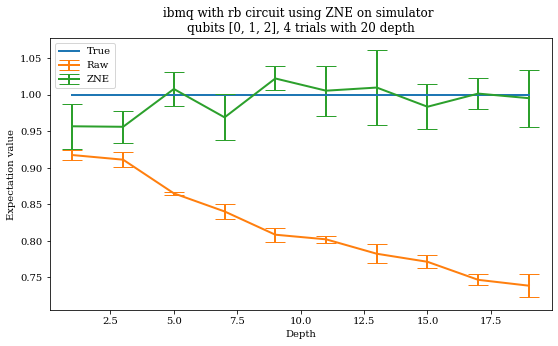

In [20]:
plt.figure(figsize=(9, 5))

kwargs = {"capsize": 10, "lw": 2}

plt.plot(depths, avg_true_values, label="True", lw=2)
plt.errorbar(depths, avg_noisy_values, yerr=std_noisy_values, label="Raw", **kwargs)

if mitigation_type == "zne":
    plt.errorbar(depths, avg_zne_values, yerr=std_zne_values, label="ZNE", **kwargs)
elif mitigation_type == "pec":
    plt.errorbar(depths, avg_pec_values, yerr=std_pec_values, label="PEC", **kwargs)
    
plt.title(f"""{hardware_type} with {circuit_type} circuit using {mitigation_type.upper()} {"on simulator" if use_noisy_simulator else ""} \nqubits {qubits}, {trials} trials with {max_depth} depth""")
plt.xlabel("Depth")
plt.ylabel("Expectation value")
plt.savefig(f"{hardware_type}_{mitigation_type}_{circuit_type}.pdf")
plt.legend();

## Save data

In [21]:
if save_data:
    dir_name = f"{hardware_type}_{mitigation_type}_{circuit_type}_nqubits_{len(qubits)}_mindepth_{min_depth}_maxdepth_{max_depth}_shots_{shots}_trials_{trials}"
    time_key = "_" + "_".join(time.asctime().split())

    try:
        os.mkdir(dir_name)
    except FileExistsError:
        pass

    np.savetxt(
        os.path.join(dir_name, "noise_scaled_expectation_values" + time_key + ".txt"), noise_scaled_expectation_values
    )
    np.savetxt(
        os.path.join(dir_name, "cnot_counts" + time_key + ".txt"), cnot_counts
    )
    np.savetxt(
        os.path.join(dir_name, "oneq_counts" + time_key + ".txt"), oneq_counts
    )
    np.savetxt(
        os.path.join(dir_name, "true_values" + time_key + ".txt"), true_values
    )
    np.savetxt(
        os.path.join(dir_name, "noisy_values" + time_key + ".txt"), noisy_values
    )
    if mitigation_type == "zne":
        np.savetxt(
            os.path.join(dir_name, "zne_values" + time_key + ".txt"), zne_values
        )
    elif mitigation_type == "pec":
        np.savetxt(
            os.path.join(dir_name, "pec_values" + time_key + ".txt"), pec_values
        )        
    
    print("Data saved succesfully in", dir_name)

Data saved succesfully in ibmq_zne_rb_nqubits_3_mindepth_1_maxdepth_20_shots_10000_trials_4
